In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import numpy as np
import json
import os
import sys
import pickle
from scipy import ndimage

# for Jupyter lab
# %matplotlib widget
# for Jupyter notebook
# %matplotlib notebook
%matplotlib inline

Fun4all_path = os.path.abspath(os.path.join('..','..','..','..','pyFunsForAll'))
sys.path.append(Fun4all_path)

from plot_fun import colorize, adjust_lightness, get_blue_map, get_red_map
from analy_fun import cpx_corr, fidelity, seq_cpx_corr, get_disk_mask
from rand_fun import rnd_cpx_disk

from pyTen.decompositions import hosvd, als3herm, als4herm2
from fisher_functions import get_W3, get_W4, normalizevecs,\
    getOutputFields, fisherPerMode, fisher, get_moim, derYop
from optimize_fisher import optimize_input

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title



plt.rc('figure', facecolor='white') # white background for VSC
cmap_int = 'afmhot'#'gist_heat'
cmap_fish = 'inferno'

function = fidelity
noise = 'gaussian'#'poisson'

data_path = os.path.abspath(os.path.join('..','..','MyData')) #pc
# data_path = os.path.abspath(os.path.join('..','..','..','My_data','GRIN')) #mac
# fig_path = os.path.abspath(os.path.join('..','Figs'))
fig_path = os.path.abspath(os.path.join('..','..','Manuscript','Figs'))

In [4]:
# i=2
# crnd = plt.cm.tab10(4)#adjust_lightness('b', amount=1.2)
# cmod = plt.cm.tab10(0)#adjust_lightness('purple', amount=1.5)
# ccra = plt.cm.tab10(1)#adjust_lightness('r', amount=1.2)
# cmii = plt.cm.tab10(3)#'orange'

cmcra = matplotlib.cm.get_cmap('Oranges')
cmrnd = matplotlib.cm.get_cmap('Purples')
cmmod = matplotlib.cm.get_cmap('Blues')
cmmii = matplotlib.cm.get_cmap('Reds')

crnd = cmrnd(1.)#adjust_lightness('b', amount=1.2)
cmod = cmmod(0.8)#adjust_lightness('purple', amount=1.5)
ccra = cmcra(0.7)#adjust_lightness('r', amount=1.2)
cmii = cmmii(0.8)#

In [5]:
def get_corrVSdx(Xs, TMs, nref=0, mask=None, remove_mean=False, inten=False):
    Ydx = getOutputFields(Xs,TMs)
    if inten==True:
        Ydx = np.abs(Ydx)**2
    sh = Ydx.shape
    if len(sh)==2:
        corr = seq_cpx_corr(Ydx,Ydx[nref], mask=mask, remove_mean=remove_mean)
    else:
        corr = np.empty(Ydx.shape[:2], complex)
        for i in range(Ydx.shape[1]):
            corr[:,i] = seq_cpx_corr(Ydx[:,i],Ydx[nref,i], mask=mask, remove_mean=remove_mean)
    return corr

def get_miis(init_seeds, Hs, n_iter=200, method='als'):
    fout = 0
    W_ten = get_W3(Hs, method='2pts')
    for n, seed in enumerate(init_seeds):
        if method == 'opt':
            F, X, evol = optimize_input(
                seed, Hs, n_epochs=n_iter,lr=1e-2,noise='gaussian')
        elif method == 'als':
            us_als, evol = als3herm(
                W_ten, 1, n_iter, init_fact_mat =seed, evol=True, special_form=False)
            X = us_als[2][:,0]
            F = fisher(X, Hs, noise='gaussian')
        else:
            raise ValueError('Invalid method')
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n
    return fout, xout, evol, nseed

def get_lim(init_seeds, Hs, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        F, X, evol = optimize_input(
            seed, Hs, n_epochs=n_iter,lr=1e-2,noise='moim')
        
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n

    return fout, xout, evol, nseed

def get_best1out(init_seeds, Hs, W4, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        us_als, evol = als4herm2(
            W4, 1, n_iter, init_fact_mat =seed, evol=True, special_form=False)
        X = us_als[3][:,0]
        moim = get_moim(X,Hs)
        F = moim[1][1]**2
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n
    return fout, xout, evol, nseed

# 1. Load data

In [6]:
with open(os.path.join(data_path, 'param.pkl'), 'rb') as file:
        param = pickle.load(file, encoding='latin1')

In [7]:
modes = np.load(os.path.join(data_path,'modes.npz'))

N_in = param['fiber']['inpoints'] 
N_out = param['fiber']['onpoints'] 
steps_pressure = param['Deformation']['steps_pressure']
n_steps = len(steps_pressure)
n_mod = param['modes']['num_modes']

In [70]:
modes_out = modes['modes_out1_corr']
modes_in = modes['modes_in_corr']

dx = 1000*param['Deformation']['press_steps_treat']

TM_full_pix = np.load(os.path.join(data_path,'TMs_pix.npy'))
TM_full_mod = np.load(os.path.join(data_path,'TMs_mode.npy'))

TM_pix = TM_full_pix[:,:N_out**2]
TM_mod = TM_full_mod[:,:n_mod] # modes_out.conj() @ TM_pix[0]@ modes_in.T

TM_mix =  TM_pix @ modes_in.T
n_sing = n_mod

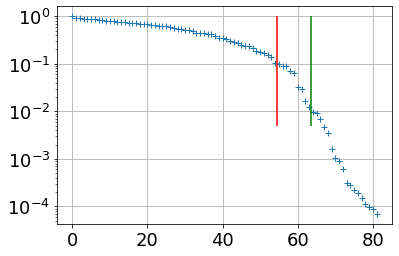

In [9]:
u, s, vh = np.linalg.svd(TM_pix[0])
fig = plt.figure()
plt.semilogy((s[:int(n_mod*1.5)]/s[0])**2,'+')
plt.vlines(n_mod-.5,0.005,1,'r')
n_sing = 64
plt.vlines(n_sing-.5,0.005,1,'g')
plt.grid(True)

# TM_mix =  TM_pix @ (vh[:n_sing].conj().T) 

# 2. Sensitivity to deformation

## 2.1 Compute crashing modes and MIIS

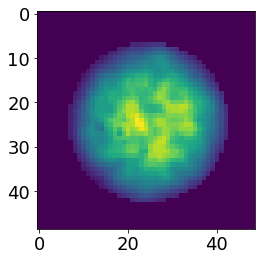

In [322]:
n_rnd = 100
X_rnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Yrnd = getOutputFields(X_rnd,TM_mix[0])
plt.imshow(np.reshape(np.mean(np.abs(Yrnd)**2,axis=0),(N_out,N_out)))
out_mask = get_disk_mask([N_out,N_out], 0.75*N_out//2, center=(N_out/2,N_out/2))
plt.imshow(out_mask*np.reshape(np.mean(np.abs(Yrnd)**2,axis=0),(N_out,N_out)))

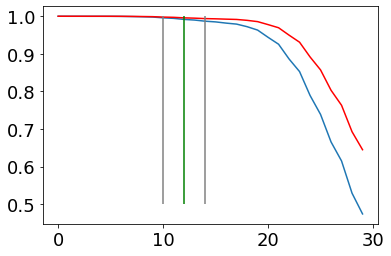

In [112]:
# central deformation to estimate the WS operator
center_TM_index = 12
# step to evaluate the derivative
step = 2

plt.plot(fidelity(TM_mod,TM_mod[0]))
plt.plot(fidelity(np.abs(TM_mod),np.abs(TM_mod[0])),c='r')
plt.vlines(center_TM_index,0.5,1,'g')
plt.vlines(center_TM_index+step,0.5,1,'gray')
plt.vlines(center_TM_index-step,0.5,1,'gray')

Hmix_list = np.array([TM_mix[center_TM_index - step], 
                      TM_mix[center_TM_index], 
                      TM_mix[center_TM_index + step]])
Hmix_list /= np.sum(np.abs(Hmix_list)**2,axis=(-1,-2),keepdims=True)
W_ten = get_W3(Hmix_list, method='2pts') # should be less susceptible to phase errors

In [96]:
np.mean(np.abs(Hmix_list)**2,axis=(-1,-2))

array([0.47644796, 0.47680056, 0.47708335])

In [97]:
np.mean(np.abs(TM_mod[center_TM_index-step])**2)

20.662459262727705

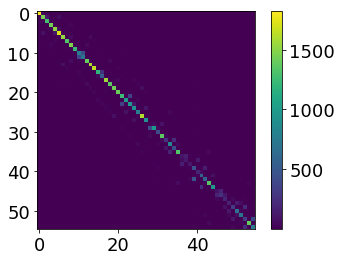

In [103]:
plt.imshow((np.abs(TM_mod[center_TM_index-step])**2))
plt.colorbar()

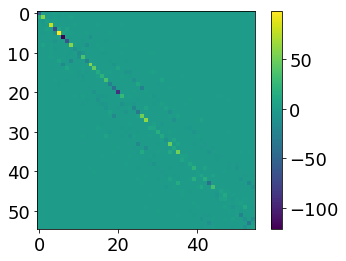

In [102]:
plt.imshow((np.abs(TM_mod[center_TM_index-step])**2-np.abs(TM_mod[center_TM_index+step])**2))
plt.colorbar()

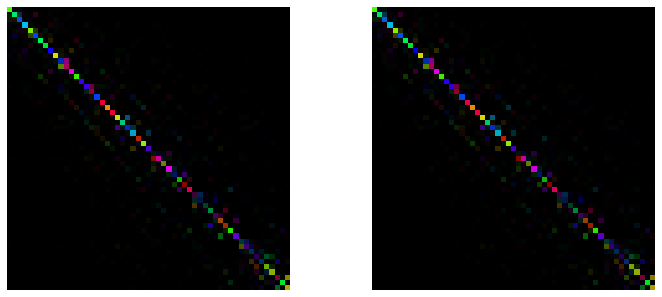

In [99]:
fig, axs = plt.subplots(1,2,figsize=(0.8*15,0.8*6.5))
phi_corr = np.exp(1j*(np.angle(TM_mod[center_TM_index-step][0,0])-np.angle(TM_mod[center_TM_index+step][0,0])))
axs[0].imshow(colorize(TM_mod[center_TM_index-step]))
axs[1].imshow(colorize(phi_corr*TM_mod[center_TM_index+step]))
for ax in axs.ravel():
    ax.axis('off')

In [113]:
us_hosvd, s_hosvd = hosvd(W_ten)
Xcrash = us_hosvd[2].T

In [114]:
opt_seeds = [us_hosvd[2][:,i] for i in range(5)]
als_seeds = [[np.sum(s_hosvd[:,i,i]*us_hosvd[0],axis=-1,keepdims=True),us_hosvd[1][:,i,None],us_hosvd[2][:,i,None]]
    for i in range(5)] # iter = 80
Fmiis, Xmiis, evol, nseed = \
    get_miis(opt_seeds, Hmix_list[::2], n_iter=400, method='opt')

In [115]:
n_rnd = 100
Xrnd = normalizevecs(rnd_cpx_disk((n_rnd,n_sing)))
Xmod = np.eye(n_sing, dtype=complex)[:n_mod]

In [116]:
Xcrash.shape

(55, 55)

In [117]:
maskc = None # 
intc = True
rm=True #False
corr_mod = np.abs(get_corrVSdx(Xmod, TM_mix, nref=center_TM_index,mask=maskc,remove_mean=rm,inten=intc))
corr_crash = np.abs(get_corrVSdx(Xcrash, TM_mix, nref=center_TM_index,mask=maskc,remove_mean=rm,inten=intc))
corr_rnd = np.abs(get_corrVSdx(Xrnd, TM_mix, nref=center_TM_index,mask=maskc,remove_mean=rm,inten=intc))
corr_miis = np.abs(get_corrVSdx(Xmiis, TM_mix, nref=center_TM_index,mask=maskc,remove_mean=rm,inten=intc))

Text(0.5, 1.0, 'Sensitivity to perturbation')

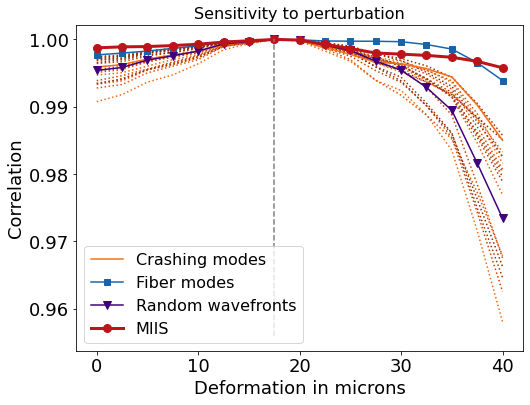

In [118]:
i0 = 5#center_TM_index-2#5#18
im = center_TM_index+10
plt.figure(figsize = (8,6))
n_mod2p = n_mod#//3
n_cra2p = n_mod//3
cmb = get_blue_map(n=n_mod2p)
cmr = get_red_map(n=n_mod2p)

dxp = dx[i0:im]
# for i in range(n_mod2p):
#     plt.plot(dxp, corr_mod[i0:im,i], color=cmmod(0.4+0.6*i/n_mod2p), ls='--')


# plt.plot(dxp, corr_crash[i0:im,0], color=cmr(n_mod2p), ls='-', label='Crashing modes')

for i in range(n_cra2p):
    plt.plot(dxp, corr_crash[i0:im,i], c=cmcra(0.6+0.4*i/n_cra2p), ls=':')#cmb(n_mod2p-i-1), ls='-')
plt.plot(dxp, corr_crash[i0:im,0], color=cmcra(0.6), ls='-', label='Crashing modes')

plt.plot(dxp, corr_mod[i0:im,0], color=cmod, ls='-',marker='s', label='Fiber modes')

plt.plot(dxp,np.mean(corr_rnd,axis=-1)[i0:im],c=crnd,markersize=8,marker='v',label='Random wavefronts')

plt.plot(dxp,corr_miis[i0:im],lw=3, c=cmii, markersize=8, marker='o',label='MIIS')

all_min = plt.gca().get_ylim()[0]
plt.vlines(dx[center_TM_index],all_min,1., 'gray', linestyles = 'dashed')
plt.legend(loc='lower left')

plt.xlabel('Deformation in microns')
plt.ylabel('Correlation')
plt.title('Sensitivity to perturbation')

# 3. Pixel Fisher and out fields

In [119]:
# Fcrash = np.empty(n_sing)
# for i in range(n_sing):
#     Fcrash[i] = fisher(us_hosvd[2][:,i], [Hmix_list[0],Hmix_list[-1]], noise=noise)
# sorted_ind = np.argsort(Fcrash)

Fcrash = fisher(Xcrash, Hmix_list, noise=noise)
Frnd = fisher(Xrnd, Hmix_list, noise=noise)
Fmod = fisher(Xmod, Hmix_list, noise=noise)


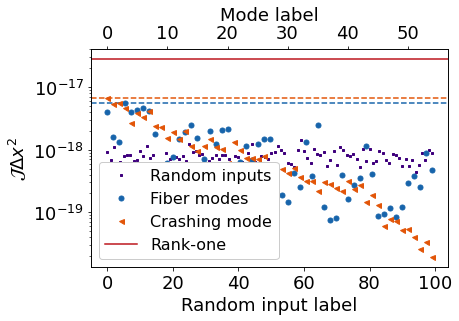

In [120]:
fig, ax = plt.subplots(1,1, figsize=(8*0.8,5*0.8))
ax2 = ax.twiny() 

# Random
ln1, = ax.plot(Frnd,'s',markersize=2, c=crnd)

# Fiber modes
ln2, = ax2.plot(np.arange(n_mod),Fmod,'o',markersize=5, c=cmod)
ax.axhline(np.max(Fmod), linestyle='--', c=cmod)

# Crashing modes
ln3, = ax2.plot(np.arange(n_mod),Fcrash[:n_mod],'<',markersize=5, c=ccra)
ax.axhline(np.max(Fcrash), linestyle='--', c=ccra)

# MIIS
ln4 = ax.axhline(Fmiis, c=cmii)

lns = [ln1,ln2,ln3,ln4]
lgd =ax2.legend(lns,['Random inputs','Fiber modes',
    'Crashing mode','Rank-one'],
    # bbox_to_anchor=(1.,.5), #bbox_to_anchor=(1.8,.5), 
    loc=3, facecolor='white',framealpha=1)
    
ax2.set_xlabel('Mode label')
ax.set_xlabel('Random input label')
ax.set_ylabel('$\mathcal{J}\Delta x^2 $')
ax.set_yscale('log')
t = ax.yaxis.get_offset_text()
t.set_x(-.1)

In [121]:
np.argmax(Fmod)

3

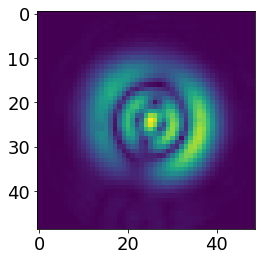

In [122]:
plt.imshow(np.abs((TM_mix[0] @ Xmod[10]).reshape(N_out,N_out)))

In [123]:
Xins = [Xrnd[0],Xmod[np.argmax(Fmod)],Xcrash[np.argmax(Fcrash)],Xmiis]
# Xins = [Xrnd[0],Xmod[0],Xcrash[np.argmax(Fcrash)],Xmiis]
def get_intNdiff(X, H):
    Ys = getOutputFields(X, H)
    Intdiff = np.abs(Ys[-1])**2-np.abs(Ys[0])**2
    return np.abs(Ys[1])**2, Intdiff
Yint, Ydiff = get_intNdiff(Xins, Hmix_list)


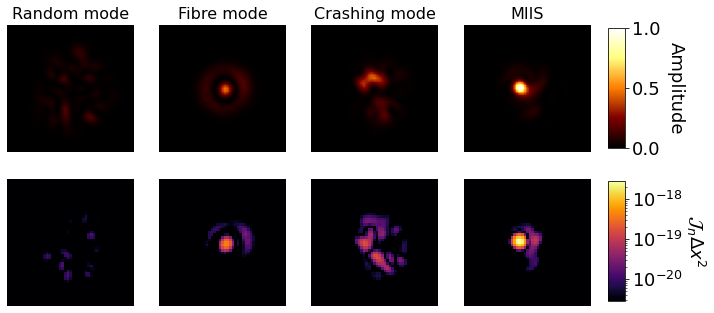

In [124]:
fmax= np.max((np.abs(Ydiff)**2).ravel())
fmin = fmax*10**(-3)
dm = np.max(Ydiff[3])
Im = np.max(Yint.ravel())
Yint /= Im

titles = ['Random mode', 'Fibre mode', 'Crashing mode', 'MIIS']
fig, axs = plt.subplots(2,4,figsize=(0.8*15,0.8*6.5))

# axs[0,0].set_ylabel('Field Intensity')

for i in range(4):
    axs[0,i].set_title(titles[i])
    if i<3:
        axs[0,i].imshow(Yint[i].reshape(N_out,N_out),vmin=0,vmax=1,cmap=cmap_int)
        axs[1,i].matshow((np.abs(Ydiff[i]).reshape(N_out,N_out))**2,
                        norm=colors.LogNorm(vmin=fmin, vmax=fmax),
                        cmap=cmap_fish)
    else:
        pl_int = axs[0,i].imshow(Yint[i].reshape(N_out,N_out),vmin=0,vmax=1,cmap=cmap_int)
        pl_fish = axs[1,i].matshow((np.abs(Ydiff[i]).reshape(N_out,N_out))**2,
                        norm=colors.LogNorm(vmin=fmin, vmax=fmax),
                        cmap=cmap_fish)
    
    # axs[2,i].imshow(Ydiff[i].reshape(N_out,N_out),vmin=-dm,vmax=dm,cmap='RdBu')#'twilight')
    # axs[2,i].imshow(Ydiff[i].reshape(N_out,N_out),cmap='twilight')

cb_width =0.02
cb_height = 0.32
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.14+0.41, cb_width, cb_height])
cbar1= fig.colorbar(pl_int, cax=cbar_ax)
cbar_ax.get_yaxis().labelpad = 24
cbar1.set_label('Amplitude', rotation=270)

cbar_ax2 = fig.add_axes([0.82, 0.14, cb_width, cb_height])
cbar2=fig.colorbar(pl_fish, cax=cbar_ax2)
cbar_ax2.get_yaxis().labelpad = 24
cbar2.set_label('$\mathcal{J}_n\Delta x^2$', rotation=270)

for ax in axs.ravel():
    ax.axis('off')

# 4. Estimating change in perturbation

# 5. Optimal output modes

## 5.1 MOIM for previous 

Change basis to speed things up

In [ ]:
udef, sdef, vhdef = np.linalg.svd(Hmix_list[1])
Hsing_list = udef[:,:len(sdef)].T.conj() @ Hmix_list
mofish = lambda mo : np.sum(np.abs(mo[1])**2, axis=-1)

In [402]:
Fmo_rnd = []
for ind in range(n_rnd//50):
    _, vals_rnd = get_moim(Xrnd[ind*50:(ind+1)*50], Hsing_list[::2])
    Fmo_rnd += np.sum(np.abs(vals_rnd)**2, axis=-1).tolist()
MOmod = get_moim(Xmod, Hsing_list[::2])
MOcrash = get_moim(Xcrash, Hsing_list[::2])
MOmiis = get_moim(Xmiis, Hsing_list[::2])

Fmo_mod = mofish(MOmod)
Fmo_crash = mofish(MOcrash)

## 5.2 Precision limit

In [432]:
W4th_tensor = get_W4(Hsing_list.astype(np.csingle))
uw4s, sw4 = hosvd(W4th_tensor)
Xw4 = uw4s[3].T
MOw4 = get_moim(Xw4, Hsing_list[::2])
Fmo_w4 = mofish(MOw4)

In [438]:
optw4_seeds = [Xw4[i] for i in range(10)]
Flim, Xlim, evol, nseed = get_lim(optw4_seeds, Hsing_list[::2], n_iter=200)

## 5.3 Best one out

In [463]:
MOw4[1][:,0]**2

array([59578.80535252+0.j, 47193.05957411-0.j, 49239.91122793-0.j,
       39940.37231375+0.j, 45115.97971341+0.j, 41419.5294538 -0.j,
       37372.11412971-0.j, 35010.77712642-0.j, 34069.68505775-0.j,
       29240.18347221+0.j, 28501.22968079-0.j, 25945.37822085+0.j,
       24810.49054516-0.j, 20950.43101608-0.j, 18651.93715406+0.j,
       19357.66393994-0.j, 16830.43685537-0.j, 15491.75654233+0.j,
       15507.72097339+0.j, 12651.70087825-0.j, 11874.48705786-0.j,
       10536.63619086-0.j,  7508.66093335-0.j,  8363.11335032+0.j,
        8656.94588781+0.j,  7439.78091481+0.j,  4547.39692322-0.j,
        5768.88629995-0.j,  6349.39157278-0.j,  5416.44150068-0.j,
        3640.80919713-0.j,  3943.4188182 +0.j,  2903.49704401-0.j,
        4192.1080138 +0.j,  2984.75836864-0.j,  3080.60988416+0.j,
        2144.47203745-0.j,  2428.83455324+0.j,  1420.50051782+0.j,
        1772.42259196-0.j,  1702.09508869+0.j,   871.00440884-0.j,
        1204.90895388+0.j,  1315.20604246-0.j,  1097.88844172-

In [473]:
MOmiis[1]**2

array([29885.54655633, 42006.32207355])

In [475]:
als4_seeds = [[uw4s[0][:,0,None],uw4s[1][:,0,None],uw4s[2][:,0,None],uw4s[3][:,0,None]]]
Fb1out, Xb1out, evol, nseed = get_best1out(als4_seeds, Hsing_list[::2], W4th_tensor,n_iter=50)

## 5.4 Plot results

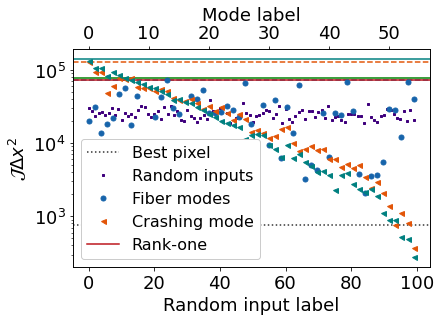

In [476]:
fig, ax = plt.subplots(1,1, figsize=(8*0.8,5*0.8))
ax2 = ax.twiny() 

# Best pix
l0 = ax.axhline(Fmiis, linestyle=':', color=adjust_lightness('gray', amount=.4))

# Random
ln1, = ax.plot(Fmo_rnd,'s',markersize=2, c=crnd)

# Fiber modes
ln2, = ax2.plot(np.arange(n_mod), Fmo_mod,'o',markersize=5, c=cmod)
ax.axhline(np.max(Fmo_mod), linestyle='--', c=cmod)

# Crashing modes
ln3, = ax2.plot(np.arange(n_mod), Fmo_crash,'<',markersize=5, c=ccra)
ax.axhline(np.max(Fmo_crash), linestyle='--', c=ccra)

# MIIS
ln4 = ax.axhline(mofish(MOmiis), c=cmii)

# sing W4
ln5, = ax2.plot(np.arange(n_mod), Fmo_w4,'<',markersize=5, c='teal')
ax.axhline(Flim, c='teal')

# best 1 out
ax.axhline(Fb1out, c='green')

lns = [l0,ln1,ln2,ln3,ln4]
lgd =ax2.legend(lns,['Best pixel','Random inputs','Fiber modes',
    'Crashing mode','Rank-one'],
    # bbox_to_anchor=(1.,.5), #bbox_to_anchor=(1.8,.5), 
    loc=3, facecolor='white',framealpha=1)
    
ax2.set_xlabel('Mode label')
ax.set_xlabel('Random input label')
ax.set_ylabel('$\mathcal{J}\Delta x^2 $')
ax.set_yscale('log')
t = ax.yaxis.get_offset_text()
t.set_x(-.1)

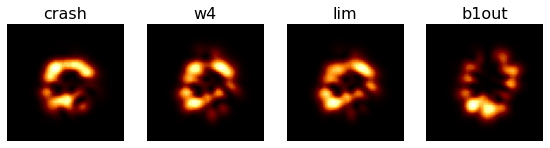

In [535]:
Ysbest =getOutputFields(np.array([Xcrash[0],Xw4[0],Xlim,Xb1out]), Hmix_list[1])

fig, axs = plt.subplots(1,4,figsize=(0.8*12,0.8*3.5))
titles = ['crash', 'w4', 'lim','b1out']
for i in range(4):
    axs[i].set_title(titles[i])
    axs[i].imshow(np.abs(Ysbest[i].reshape(N_out,N_out))**2,cmap=cmap_int)
for ax in axs.ravel():
    ax.axis('off')

# 6. Optimal output basis

In [477]:
Hmod_list = np.array([TM_mod[center_TM_index - step], 
                      TM_mod[center_TM_index], 
                      TM_mod[center_TM_index + step]])
n_moims = n_mod
sing_moims = uw4s[0][:,:n_moims]/(np.sum(np.abs(uw4s[0][:,:n_moims])**2,axis=0, keepdims=True))**(1/2)
Hhosvd_list = sing_moims.T.conj()@Hsing_list

In [484]:
n_rnd = 10000
Xrnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Frnd_pix = fisher(Xrnd, Hmix_list, noise=noise)
Frnd_mod = fisher(Xrnd, Hmod_list, noise=noise)
Frnd_svd = fisher(Xrnd, Hsing_list, noise=noise)
Frnd_hosvd = fisher(Xrnd, Hhosvd_list, noise=noise)


In [503]:
Frnd10_mod = fisher(Xrnd, Hmod_list[:,:10], noise=noise)
Frnd10_svd = fisher(Xrnd, Hsing_list[:,:10], noise=noise)
Frnd10_hosvd = fisher(Xrnd, Hhosvd_list[:,:10], noise=noise)

In [517]:
nbas = 5
Frnd2_mod = fisher(Xrnd, Hmod_list[:,:nbas], noise=noise)
Frnd2_svd = fisher(Xrnd, Hsing_list[:,:nbas], noise=noise)
Frnd2_hosvd = fisher(Xrnd, Hhosvd_list[:,:nbas], noise=noise)

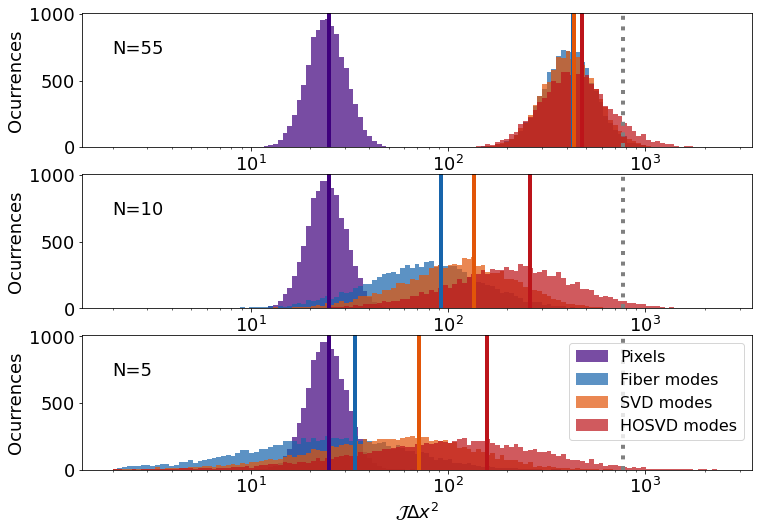

In [530]:
Fsrnd = np.array([Frnd_pix, Frnd_mod, Frnd_svd, Frnd_hosvd])
lw=4
lbs = ['Pixels', 'Fiber modes', 'SVD modes', 'HOSVD modes']
nlist = ['55','10','5']
chist = [crnd, cmod, ccra, cmii]
fig, axs = plt.subplots(3,1,figsize=(0.8*15,0.8*10.5))
bins = np.geomspace(2., Fsrnd.ravel().max(), 130)
for i, d in enumerate([Frnd_pix, Frnd_mod, Frnd_svd, Frnd_hosvd]):
    axs[0].hist(d, bins=bins, alpha=0.7, color=chist[i])
    axs[0].axvline(x=np.mean(d), c=chist[i],linewidth=lw)
for i, d in enumerate([Frnd_pix, Frnd10_mod, Frnd10_svd, Frnd10_hosvd]):
    axs[1].hist(d, bins=bins, alpha=0.7, color=chist[i])    
    axs[1].axvline(x=np.mean(d), c=chist[i],linewidth=lw)
for i, d in enumerate([Frnd_pix, Frnd2_mod, Frnd2_svd, Frnd2_hosvd]):
    axs[2].hist(d, bins=bins, alpha=0.7, color=chist[i], label=lbs[i])    
    axs[2].axvline(x=np.mean(d), c=chist[i],linewidth=lw)
for i, ax in enumerate(axs.ravel()):
    ax.set_xscale('log')
    ax.axvline(x=Fmiis, c='gray',linestyle=':',linewidth=lw)
    ax.set_ylabel('Ocurrences')
    ax.text(2,700,'N='+nlist[i], fontsize=MEDIUM_SIZE)
axs[2].set_xlabel('$\mathcal{J}\Delta x^2 $')
axs[2].legend(loc='upper right') 